In [3]:
from qiskit_ibm_provider import IBMProvider
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qiskit import pulse, QuantumCircuit,transpile, schedule
# from qiskit.pulse import transforms, Acquire, AcquireChannel, MemorySlot, Schedule, Play, library
# from qiskit_dynamics.pulse import InstructionToSignals
from qiskit.circuit import Gate, Parameter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from scipy.signal import convolve
import pandas as pd
from numpy.polynomial.chebyshev import Chebyshev
from qiskit_dynamics import DiscreteSignal
from qiskit_experiments.calibration_management.calibrations import Calibrations

provider = IBMProvider(name="dev-iqp")
# provider = IBMProvider(instance="ibm-q-internal/internal-test/bichromatic")
backend = provider.get_backend("test_whiplash")

In [67]:

qubit = 6
cals = Calibrations.from_backend(backend)
print(cals.get_inst_map())

<InstructionScheduleMap(1Q instructions:
Multi qubit instructions:
)>


In [68]:
def setup_cals(backend) -> Calibrations:

    cals = Calibrations.from_backend(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp_long") as xp_long:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    cals.add_schedule(xp_long, num_qubits=1)

    return cals

# Add guesses for the parameter values to the calibrations.
def add_parameter_guesses(cals: Calibrations):

    for sched in ["xp_long"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

In [73]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

In [76]:
cals.get_schedule('xp_long',[6])

ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0.5, amp=0.5, angle=0), DriveChannel(6)), name="xp_long", transform=AlignLeft())

In [70]:
columns_to_show = ["parameter", "qubits", "schedule", "value", "date_time"]
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()]))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,meas_freq,"(6,)",None,7.393744e+09,2023-06-19 09:52:16.818536-0400
1,amp,(),xp_long,5.000000e-01,2023-06-19 09:52:16.861742-0400
2,σ,(),xp_long,8.000000e+01,2023-06-19 09:52:16.819122-0400
3,drive_freq,"(6,)",None,5.088242e+09,2023-06-19 09:52:16.818405-0400
4,β,(),xp_long,5.000000e-01,2023-06-19 09:52:16.835323-0400
5,dur,(),xp_long,3.200000e+02,2023-06-19 09:52:16.849807-0400


In [85]:
from qiskit_experiments.library.calibration import RoughAmplitudeCal
rabi = RoughAmplitudeCal([6], cals, schedule_name='xp_long', backend=backend, amplitudes=np.linspace(-0.1, 0.1, 51))

In [86]:
rabi_data = rabi.run().block_for_results()

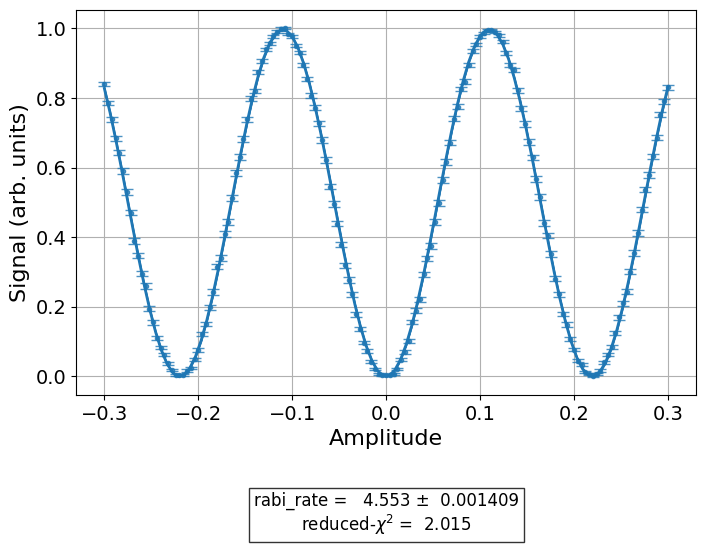

In [87]:
rabi_data.figure(0)

In [88]:
pd.DataFrame(**cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))[columns_to_show]

,parameter,qubits,schedule,value,date_time
0,amp,(),xp_long,0.500000+0.000000j,2023-06-19 09:55:07.563972-0400
1,amp,"(6,)",xp_long,0.109821+0.000000j,2023-06-19 10:07:34.490997-0400


In [89]:
cals.get_schedule('xp_long',[6])

ScheduleBlock(Play(Drag(duration=320, sigma=80, beta=0.5, amp=0.10982139, angle=0), DriveChannel(6)), name="xp_long", transform=AlignLeft())

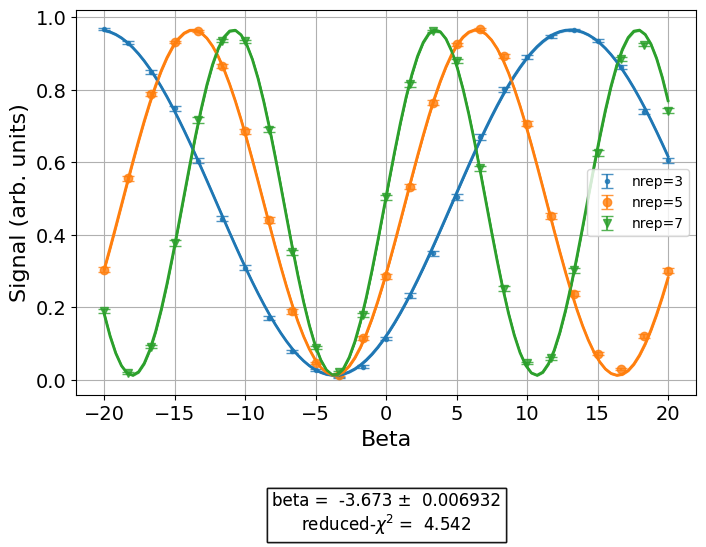

In [107]:
from qiskit_experiments.library import RoughDragCal, FineDragCal

cal_drag = RoughDragCal([qubit],cals,schedule_name='xp_long',backend=backend,betas=np.linspace(-20,20,25))
cal_drag.set_experiment_options(reps=[3, 5, 7])
drag_data = cal_drag.run().block_for_results()
drag_data.figure(0)

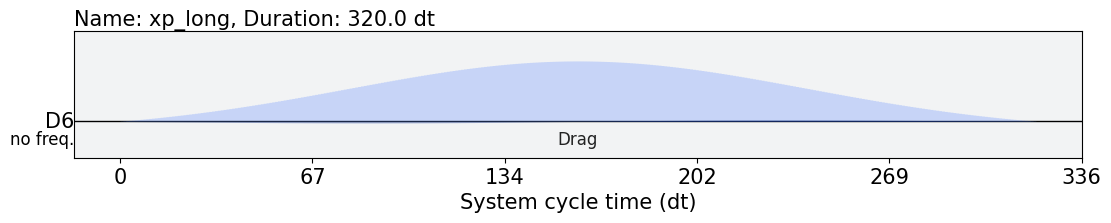

In [113]:
cals.get_schedule('xp_long',[6]).draw()

In [130]:
cals.get_schedule('xp_long',[6]).duration*config.dt*1e9

71.11111111111111

In [124]:
calibrations = defaults.instruction_schedule_map
xp_schedule = calibrations.get('x', [qubit])
xp_schedule.duration*config.dt*1e9

35.55555555555556